In [1]:
import numpy as np
import tensorflow as tf
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 24})
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
#Get MNIST data from tensorflow
dataset = tf.contrib.learn.datasets.load_dataset('mnist')
X_train = dataset.train.images
Y_train = dataset.train.labels
Y_train_1hot = np.eye(Y_train.max()+1)[Y_train]

X_test = dataset.test.images
Y_test = dataset.test.labels
Y_test_1hot = np.eye(Y_test.max()+1)[Y_test]

print "X_train shape = {}".format(X_train.shape)
print "Y_train shape = {}".format(Y_train.shape)
print "Y_train_1hot shape = {}".format(Y_test_1hot.shape)
print "X_test shape = {}".format(X_test.shape)
print "Y_test shape = {}".format(Y_test.shape)
print "Y_test_1hot shape = {}".format(Y_test_1hot.shape)

Couldn't import dot_parser, loading of dot files will not be possible.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
X_train shape = (55000, 784)
Y_train shape = (55000,)
Y_train_1hot shape = (10000, 10)
X_test shape = (10000, 784)
Y_test shape = (10000,)
Y_test_1hot shape = (10000, 10)


In [3]:
#Store data dimensions
N = X_train.shape[0]
H = X_train.shape[1]
pixel_dimensions = int(np.sqrt(H))
num_classes = Y_train.max()+1

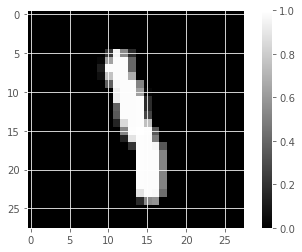

In [4]:
#Plot a random digit to see what the data looks like
index = np.random.randint(N)
img = X_train[index,:].reshape((pixel_dimensions,pixel_dimensions))
plt.figure()
plt.imshow(img,cmap='gray')
plt.colorbar()
plt.show()
plt.close()

In [5]:
#Set up deep learning parameters
Nlayers = 3
layer_dims = [300,100,10]
activation = tf.nn.relu
initialization = 1e-3

learning_rate = 1e-2
num_iterations = 4000
batch_size = 32
momentum = 0.9
print_every = 100

In [6]:
#Define a convenience function for fully connected layers
def fully_connected(x, output_units=100, activation=tf.identity, std=1e-3,
                   scope='fc', reuse=False):
  """
  args:
      x, (tf tensor), tensor with shape (batch,width,height,channels)
      std, (float/string), std of weight initialization, 'variance' for variance
          scaling
      output_units,(int), number of output units for the layer
      activation, (tf function), tensorflow activation function, e.g. tf.nn.relu
      scope, (string), scope under which to store variables
      reuse, (boolean), whether we want to reuse variables that have already
          been created (i.e. reuse an earilier layer)
  returns:
      a, (tf tensor), the output of the fully_connected layer, has size
          (batch, output_units)
  """
  with tf.variable_scope(scope, reuse=reuse):
    s = x.get_shape().as_list()

    shape = [s[1], output_units]

    if std == 'variance':
      std = np.sqrt(2.0 / shape[0])

    W = tf.get_variable('W', shape=shape, initializer=tf.random_normal_initializer(0.0, std))
    b = tf.get_variable("b", shape=shape[1], initializer=tf.random_normal_initializer(0.0, std))

    h = tf.matmul(x, W) + b
    a = activation(h)
    return a

In [7]:
#Build tensorflow graph
x_tf = tf.placeholder(dtype=tf.float32, shape=[None, H])
y_tf = tf.placeholder(dtype=tf.float32, shape=[None, num_classes])

scope = 'layer_1'
num_units = layer_dims[0]
o = fully_connected(x_tf, num_units,activation,initialization,scope)

for i in range(1,Nlayers-1):
    scope = 'layer_{}'.format(i+1)
    num_units = layer_dims[i]
    o = fully_connected(o, num_units, activation,initialization,scope)
    
scope = 'layer_final'
num_units = layer_dims[-1]
o = fully_connected(o, num_units, tf.identity, initialization, scope)

yhat = tf.nn.softmax(o)

In [8]:
#Build loss function and optimizers
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=o,labels=y_tf))

optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
            momentum=momentum)

train_op = optimizer.minimize(loss)

In [9]:
#define a convenience function to get data batches during training
def get_batch(xdata, ydata, nbatch):
    N = len(ydata)
    inds = np.random.choice(N, size=nbatch, replace=True)
    xret = xdata[inds,:]
    if len(ydata.shape) == 1:
        yret = ydata[inds]
    else:
        yret = ydata[inds,:]
    return (xret,yret)

In [10]:
#create and initialize the tensorflow session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

In [11]:
#finally execute the training loop
output = {}
output['train_loss'] = []
output['test_loss'] = []
    
for i in range(num_iterations):
    
    x,y = get_batch(X_train,Y_train_1hot,batch_size)
    
    sess.run(train_op,{x_tf:x,y_tf:y})

    if i%print_every == 0:
        
        l_train = sess.run(loss,{x_tf:x,y_tf:y})
        
        x,y = get_batch(X_test,Y_test_1hot,batch_size)
        l_test = sess.run(loss,{x_tf:x ,y_tf:y})
        
        output['train_loss'].append(l_train)
        output['test_loss'].append(l_test)
        
        print "iteration {}: train loss={}, test loss={}".format(i,l_train,l_test)

iteration 0: train loss=2.30228066444, test loss=2.30238437653
iteration 100: train loss=2.30193972588, test loss=2.29969978333
iteration 200: train loss=2.30204725266, test loss=2.2852807045
iteration 300: train loss=2.30896067619, test loss=2.31279420853
iteration 400: train loss=2.28150200844, test loss=2.30062150955
iteration 500: train loss=2.29884147644, test loss=2.28406381607
iteration 600: train loss=2.29458975792, test loss=2.31064414978
iteration 700: train loss=2.29876422882, test loss=2.30203819275
iteration 800: train loss=2.29768562317, test loss=2.30639123917
iteration 900: train loss=2.32219362259, test loss=2.30326795578
iteration 1000: train loss=2.31282806396, test loss=2.31459927559
iteration 1100: train loss=2.30101060867, test loss=2.29114365578
iteration 1200: train loss=2.29328536987, test loss=2.30624341965
iteration 1300: train loss=2.30693149567, test loss=2.31715631485
iteration 1400: train loss=2.30281829834, test loss=2.31672334671
iteration 1500: train l

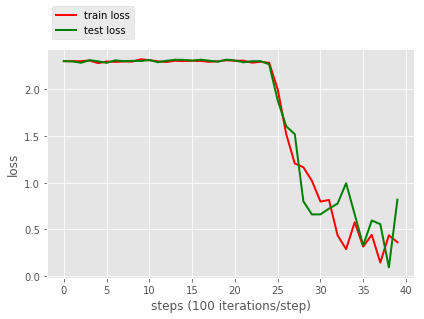

In [12]:
#plot the training and test loss
plt.figure()
plt.plot(output['train_loss'],color='r',linewidth=2,label='train loss')
plt.plot(output['test_loss'],color='g',linewidth=2,label='test loss')
plt.legend()
plt.xlabel('steps ({} iterations/step)'.format(print_every))
plt.ylabel('loss')
lgd = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=1)
plt.grid('on')
plt.tight_layout()
plt.savefig('mnist_loss.pdf',bbox_extra_artists=(lgd,),bbox_inches='tight',dpi=600)
plt.show()
plt.close()

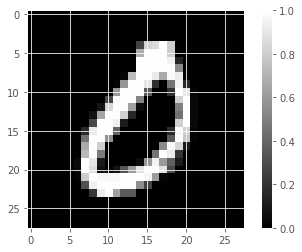

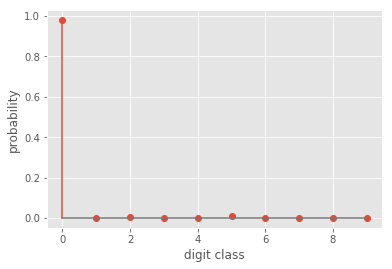

In [13]:
#Plot a random digit and the corresponding network output to see
#how well our network is working
index = np.random.randint(X_test.shape[0])
img = X_test[index,:].reshape((pixel_dimensions,pixel_dimensions))
plt.figure()
plt.imshow(img,cmap='gray')
plt.colorbar()
plt.savefig('probability_digit.pdf',dpi=600)
plt.show()
plt.close()

#We need a batch dimension so we reshape the vector to (1,784)
input_vector = X_test[index,:].reshape((1,H))
class_probabilities = sess.run(yhat,{x_tf:input_vector})

plt.figure()
plt.stem(class_probabilities[0])
plt.xlabel('digit class')
plt.ylabel('probability')
plt.savefig('probability.pdf',dpi=600)
plt.show()
plt.close()

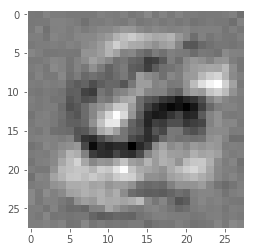

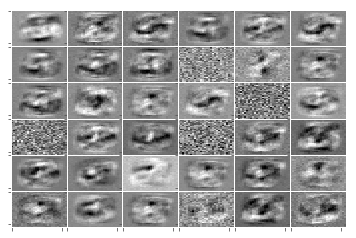

In [16]:
#look at the learned weights
weight_var = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "layer_1/W")[0]

W = sess.run(weight_var)
W = W.reshape((pixel_dimensions,pixel_dimensions,W.shape[1]))

plt.figure()
plt.imshow(W[:,:,2],cmap='gray')
plt.grid('off')
plt.savefig('mnist_weight_single.pdf',dpi=600)
plt.show()
plt.close()

plt.figure()
Nplots = 6
f, axarr = plt.subplots(Nplots, Nplots)
count = 0
for i in range(Nplots):
    for j in range(Nplots):
        axarr[i, j].imshow(W[:,:,count], cmap='gray')
        axarr[i,j].set_aspect('auto')
        axarr[i,j].grid('off')
        count += 1
        # Fine-tune figure; hide x ticks for top plots and y ticks for right plots
        plt.setp(axarr[i,j].get_xticklabels(), visible=False)
        plt.setp(axarr[i,j].get_yticklabels(), visible=False)

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('mnist_weights.pdf', dpi=600)
plt.show()
plt.close()

Accuracy for class 0 = 95.612244898%
Accuracy for class 1 = 96.8281938326%
Accuracy for class 2 = 88.2751937984%
Accuracy for class 3 = 81.7821782178%
Accuracy for class 4 = 88.6965376782%
Accuracy for class 5 = 87.668161435%
Accuracy for class 6 = 95.5114822547%
Accuracy for class 7 = 86.2840466926%
Accuracy for class 8 = 76.6940451745%
Accuracy for class 9 = 90.485629336%


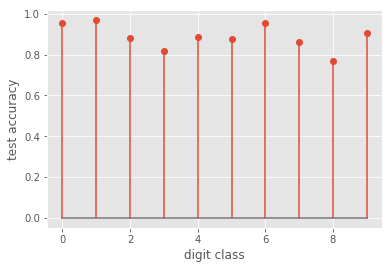

In [15]:
#calculate the accuracy for each class
predicted_probabilities = sess.run(yhat,{x_tf:X_test})
predicted_classes = np.argmax(predicted_probabilities,axis=1)

accuracies = []
for i in range(num_classes):
    class_indices = np.where(Y_test==i)[0]
    total_correct = np.sum(predicted_classes[class_indices]==Y_test[class_indices])
 
    acc = 1.0*total_correct/len(class_indices)
    accuracies.append(acc)
    print "Accuracy for class {} = {}%".format(i,acc*100)
    
plt.figure()
plt.stem(accuracies)
plt.xlabel('digit class')
plt.ylabel('test accuracy')
plt.savefig('accuracy.pdf',dpi=600)
plt.show()
plt.close()